<a href="https://colab.research.google.com/github/esemlak/esemlak/blob/main/billiard_csv_tensorflow_model_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [363]:
#!unzip -o /content/colab_train_big.zip
!pip3 install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [364]:
DATASET_PATH = "/content/colab_train_big.csv"
LABEL_NAME = "SCORE"

# "r" for regression and "c" for classification
# for classification, the number of output nodes is automatically determined
TASK = "r"

# don't change the dummy batch size. There is a small bug in tensorflow.
# to get around that bug, dummy batch size is used
DUMMY_BATCH_SIZE = 5
BATCH_SIZE = 100
EPOCHS = 100
TRAIN_FRAC = 0.8

CHECKPOINT_DIR = "/content/"

In [365]:
from collections import defaultdict
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import kerastuner as kt

import IPython

# This function will give us a fresh dataset object

In [366]:
def get_dataset(batch_size = 5):
    return tf.data.experimental.make_csv_dataset(
        DATASET_PATH,
        batch_size = batch_size,
        label_name = LABEL_NAME,
        num_epochs = 1,
        field_delim= ';'
    )

# If classification, Find Number of labels (for output nodes)

In [367]:
unique_labels = set()

unique_labels.add("VX")
unique_labels.add("VY")
num_labels = len(unique_labels)

OUTPUT_NODES = num_labels
    
print(unique_labels)

print("output nodes: ", OUTPUT_NODES)

{'VY', 'VX'}
output nodes:  2


**Test**

In [368]:
model_inputs = {}

#dataset = tf.data.experimental.make_csv_dataset(
#        DATASET_PATH,
#        batch_size = DUMMY_BATCH_SIZE,
#        label_name = LABEL_NAME,
#        num_epochs = 1,
#        header = True,
#    )

#iterator = dataset.as_numpy_iterator()
#print(next(iterator))

# Creating the Model Inputs as a dictionary

In [369]:
model_inputs = {}

for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
    for col_name, col_values in batch.items():
        if (col_name == 'X1' or col_name == 'X2' or col_name == 'X3' or col_name == 'X4' or col_name == 'Y1' or col_name == 'Y2' or col_name == 'Y3' or col_name == 'Y4'):
          model_inputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=col_values.dtype)

In [370]:
model_inputs

{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>}

## split these inputs into their own dictionaries based on the data type

In [371]:
float_inputs = {}

for col_name, col_input in model_inputs.items():
  
    
    if col_input.dtype == tf.float32:
        float_inputs[col_name] = col_input
    


In [372]:
float_inputs

{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>}

In [373]:
def numerical_input_processor(inputs):
    if not inputs:
        return
    
    concat = None
    if len(inputs.values()) > 1:
        concat = tf.keras.layers.Concatenate()(list(inputs.values()))
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()

    for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)    

        norm.adapt(data)

    # mean_log = []

    for batch, _ in get_dataset(batch_size=BATCH_SIZE):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)

        norm.adapt(data)        
        # mean_log.append(norm.mean.numpy())    

    if concat is not None:
        numeric_layer = norm(concat)
    else:
        numeric_layer = norm(list(inputs.values())[0])
    
    return numeric_layer

## PreProcess the inputs

In [374]:
float_layer = numerical_input_processor(float_inputs)

In [375]:
float_layer

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'normalization_7')>

## add all the input layers to a list

## Create a preprocessing keras model

In [376]:
preprocessing_head = tf.keras.Model(model_inputs, float_layer)

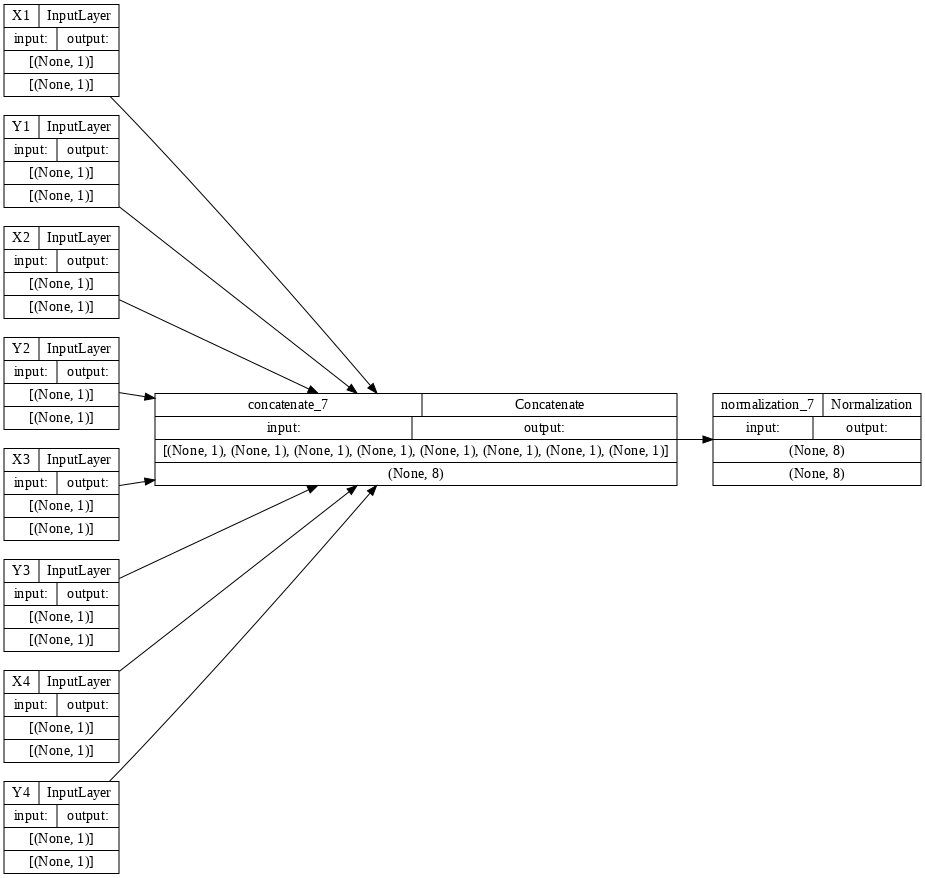

In [377]:
tf.keras.utils.plot_model(model = preprocessing_head, rankdir="LR", dpi=72, show_shapes=True, expand_nested=True, to_file="preprocessing_head.png")

## You can also see the preprocessed outputs for the given inputs

In [378]:
# preprocessing_head({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

# preprocessing_head({
#     "age" : np.array([22.0]),
#     "fare" : np.array([7.25]),
# })

## pass the model_inputs through the preprocessing_head

In [379]:
preprocessed_outputs = preprocessing_head(model_inputs)

In [380]:
num_preprocessed_outputs = list(preprocessed_outputs.shape)[-1]

In [381]:
num_preprocessed_outputs

8

## Find out how many batches should be used for training and how many for validation

In [382]:
dataset_size = 0

for _ in get_dataset(batch_size=BATCH_SIZE):
    dataset_size += 1

In [383]:
train_size = int(TRAIN_FRAC * dataset_size)

In [384]:
print(dataset_size)
print(train_size)

296
236


## Split the training and validation datasets


In [385]:
dataset = get_dataset(batch_size=BATCH_SIZE)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Set a caching mechanism that prefetches the next batch while the current batch is training

In [386]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## define early stopping and checkpointing callbacks

In [387]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, "M.{epoch:02d}-{val_loss:.2f}"))

In [388]:
callbacks = [
    early_stopping_callback,
    checkpoint_callback,
]

In [389]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

## model builder function is used by keras-tuner to find the best parameters for a model

In [390]:
def model_builder(hp):
    loss_fn = {'xv_output': 'mse', 'yv_output': 'mse'}

    metrics={'xv_output':tf.keras.metrics.RootMeanSquaredError(), 'yv_output':tf.keras.metrics.RootMeanSquaredError()}
 
    kernel_hp = hp.Choice('kernel_regularization', values = [0.01, 0.001, 0.0001, 0.00001])
    activation_hp = hp.Choice("activation", values=["elu", "relu"])
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=train_size*1000,
        decay_rate=1,
        staircase=False
    )

    first_dense = tf.keras.layers.Dense(units='8', activation='relu')(model_inputs)
    
    # XV output will be fed from the first dense
    xv_output = tf.keras.layers.Dense(units='1', name='xv_output')(first_dense)
    
    second_dense = tf.keras.layers.Dense(units='8',activation='relu')(first_dense)
    
    # YV output will be fed from the second dense
    yv_output = tf.keras.layers.Dense(units='1',name='yv_output')(second_dense)

    
    model = tf.keras.Model(inputs = model_inputs, outputs = [xv_output, yv_output])
    
    model.compile(loss=loss_fn, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                  metrics=metrics
    )
  
    return model



## initialize keras tuner

In [391]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_dir',
                     project_name = 'tuner')

ValueError: ignored

In [ ]:
tuner.search(
    train_dataset, 
    validation_data=val_dataset,
    epochs=10,
    callbacks = [ClearTrainingOutput()]
)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## These are the best model parameters

In [ ]:
best_hps.values

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model = model, rankdir="LR", dpi=96, show_shapes=True, expand_nested=True, to_file="model.png")

## Find out training and validation losses with untrained model

In [ ]:
# loss with un-trained model
model.evaluate(train_dataset)

In [ ]:
# val_loss with un-trained model
model.evaluate(val_dataset)

## Train the model

In [ ]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    callbacks=callbacks,
    epochs=EPOCHS)

## Find out training and validation losses with trained model

In [ ]:
# loss with trained model
model.evaluate(train_dataset)

In [ ]:
# val_loss with trained model
model.evaluate(val_dataset)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

In [ ]:
if TASK == "c":
    plot_acc(history)

## Test the model on some dummy data

In [ ]:
# model.predict({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

In [ ]:
# reloaded = tf.keras.models.load_model("models/titanic_model.24-1610.52")

In [ ]:
# reloaded.evaluate(train_dataset)

In [ ]:
# reloaded.evaluate(val_dataset)